<a href="https://colab.research.google.com/github/Kristelwen/TM10007_PROJECT/blob/master/brat_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment
Kristel, Lalot, Marijn, Tahisa



---


# Outline opdracht


---


Gebaseerd op beeldvorming moeten we eruit kunnen halen wat voor een soort tumor het is?
Je wil weten of het HIGH of LOW grade is.

In [44]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/Kristelwen/TM10007_PROJECT

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [0]:
# Importing modules
# General packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from time import time
from sklearn import datasets as ds

# Preprocessing packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

# Regularization
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel

In [46]:
# Data loading functions. Uncomment the one you want to use
# from adni.load_data import load_data
from brats.load_data import load_data
#from hn.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 167
The number of columns: 725


In [0]:
data_top = data.head()  

# display  
# data_top 

# Preprocessing

In [0]:
# Drop columns which contain NaN values
threshold = math.floor(len(data)/2)  # calculate threshold, half of total rows
data_drop = data.dropna(thresh=threshold, axis=1)  # Delete columns/features with more than 'threshold' NaNs
data_drop = data_drop.dropna(axis=0)  # Delete rows/subjects with NaNs
# print(data_drop)

# Split data and labels
labels = data_drop['label']
data_drop = data_drop.drop(columns="label")  # Data without labels

# Convert labels 'GBM' and 'LGG' to respectively 0 and 1
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Delete columns with strings (2 columns)
# data_strings = data_drop.select_dtypes(include=[object])
# columns_strings = list(data_strings.columns)
# data_no_strings = data_drop.drop(columns_strings, axis=1)

# Replace infinity values with NaN
#data_no_strings = data_no_strings.replace([np.inf, -np.inf], np.nan)
# print(np.isinf(data_no_strings.values).any()) - check if dataframe contains infinity values

# Feature scaling
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data_drop.values)
data_df = pd.DataFrame(data_scaled, index = data_drop.index, columns = data_drop.columns)

# Split the data in a train (80%) and test set (20%) - OF MOET DIT VOOR FEATURE SCALING? Omdat je niks mag fitten op testdata
data_train, data_test, label_train, label_test = train_test_split(data_df, labels, test_size=0.1)
# data_train, data_validation, label_train, label_validation = train_test_split(data_train, label_train, test_size=0.1)

# PCA
  # Training set
pca_train = PCA(n_components=80)  # Create a PCA with 20 components
pca_train.fit(data_train)  # Fit PCA
data_train_pca = pca_train.transform(data_train)  # Transform train data using PCA
df_train_pca = pd.DataFrame(data_train_pca, index = data_train.index)  # Put train data back in dataframe with 20 most important features
  # Validatie set
data_val_pca = pca_train.transform(data_validation)  # Transform test data using PCA

  # Test set
data_test_pca = pca_train.transform(data_test)  # Transform test data using PCA


# Learning curves & bias variance dillema

In [0]:
# print(df_train_pca)
# pd.DataFrame(data_val_pca)


## Random Forest Classifier definitie

In [32]:
#Random Forest classifier as a function 
def RandomForest(n_trees,data_train,data_test,labels_train,labels_test):
  clf = RandomForestClassifier(n_estimators=n_trees, bootstrap=True)
  clf.fit(data_train,labels_train)
  predictions = clf.predict(data_test)
  n_samples=len(data_test)
  error = (sum(abs(predictions - labels_test))/n_samples)*100
  error = (round(error, 2))
  accuracy=100-error
  return (accuracy)


acc = RandomForest(100,data_train_pca,data_val_pca,label_train,label_validation)
print(f'Accuracy of Random Forest Classifier is {acc}')

Accuracy of Random Forest Classifier is 85.71000000000001


## Ridgen

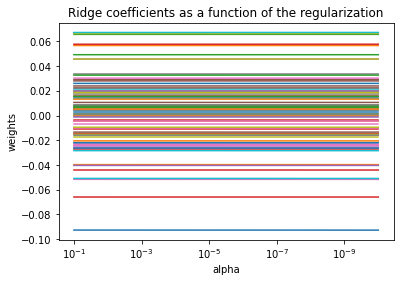

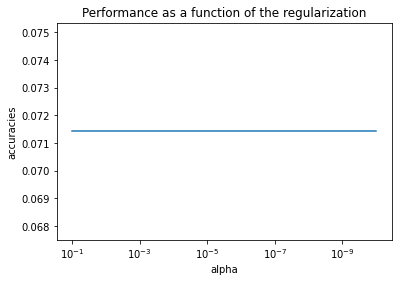

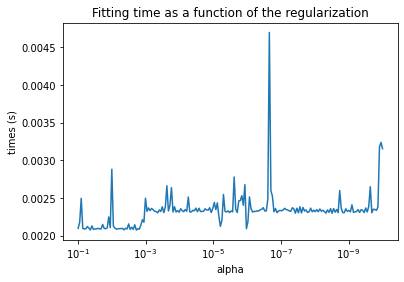

In [33]:
# Display the weights and compute error for multiple values for alpha
n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)

# Construct classifiers
coefs = []
accuracies = []
times = []
for a in alphas:
    # Fit classifier
    clf = RidgeClassifier(alpha=a, fit_intercept=False)
    t0 = time()
    clf.fit(data_train_pca, label_train)
    duration = time() - t0
    val_pred = clf.predict(data_val_pca)
    message = ("\t Misclassified: %d / %d" % ((label_validation != val_pred).sum(), label_validation.shape[0]))
    # print(message)
    
    # Append statistics
    accuracy = float((label_validation != val_pred).sum()) / float(label_validation.shape[0])
    times.append(duration)
    accuracies.append(accuracy)
    coefs.append(clf.coef_)

# #############################################################################
# Display results

# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')
plt.show()

# Times
plt.figure()
ax = plt.gca()
ax.plot(alphas, times)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('times (s)')
plt.title('Fitting time as a function of the regularization')
plt.axis('tight')
plt.show()


## Learning Curves

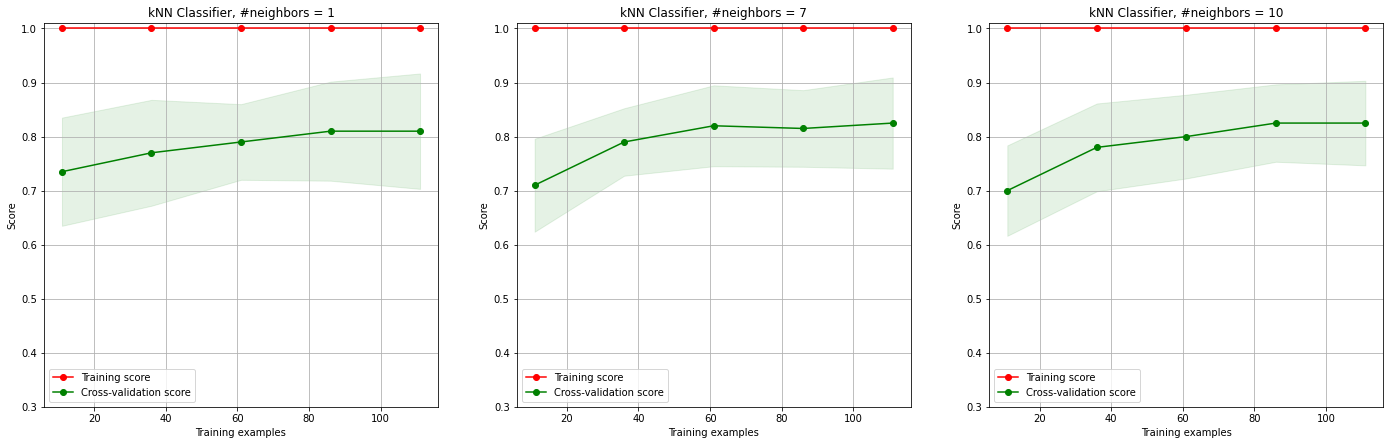

In [56]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt


# First make plot without classifiers:
# Construct classifiers
svmlin = SVC(C=2, kernel='linear', gamma='scale') # linear kernel 
svmrbf = SVC(C=2, kernel='rbf', gamma='scale') # radial basis function kernel 
svmpoly = SVC(C=2, kernel='poly', degree=3, gamma='scale') # polynomial kernel

clsfs = [
         RandomForestClassifier(n_estimators=5, min_samples_leaf=3, max_features='auto', random_state=0, bootstrap=True),
         RandomForestClassifier(n_estimators=20, min_samples_leaf=3, random_state=0, bootstrap=True),
         RandomForestClassifier(n_estimators=50, min_samples_leaf=3, random_state=0, bootstrap=True),
         svmlin, svmrbf, svmpoly,
         KNeighborsClassifier(n_neighbors=1, weights='distance'),
         KNeighborsClassifier(n_neighbors=7, weights='distance'),
         KNeighborsClassifier(n_neighbors=10, weights='distance')
        ]

# Plot figuren
fig = plt.figure(figsize=(24,8*len(clsfs)))
# ax.scatter(data_train_pca[:, 0], data_train_pca[:, 1], marker='o', c=label_train,
#     s=25, edgecolor='k', cmap=plt.cm.Paired)
    
        
# Create a cross-validation object
cv = ShuffleSplit(n_splits=10, test_size=0.15, random_state=0)
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=0)

# Now use the classifiers on all datasets
num = 0
for clf in clsfs:
    # Split data in training and testing
    # title = str(type(clf))
    if hasattr(clf, 'n_estimators'):
        title = f"Random Forest Classifier, n(trees) = {clf.n_estimators}"
    elif hasattr(clf, 'C'):
        title = f"SVM Classifier, C (slack) = {clf.C}"
    elif hasattr(clf, 'n_neighbors'):
        title = f"kNN Classifier, #neighbors = {clf.n_neighbors}"
    ax = fig.add_subplot(len(clsfs), 3, num + 1)
    plot_learning_curve(clf, title, data_train_pca, label_train, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1
